# Reddit Analysis - NLP

The goal of this NLP assignment is to further explore and analyze our text data by following basic NLP pipelines and build a sentiment model.

### Initializing Spark Session

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col, lit
from pyspark.sql import SparkSession

In [3]:
# Starting spark session
spark = SparkSession.builder \
        .appName("RedditNLP") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.4.2") \
    .master('yarn') \
    .getOrCreate()

Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7cc376ac-7d5d-4dac-a7e1-2165aa9c2b2a;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.4.2 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found

In [4]:
spark

In [5]:
!/mnt/miniconda/bin/pip install sparknlp

In [6]:
!/mnt/miniconda/bin/pip install altair

In [7]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import Finisher, DocumentAssembler

In [8]:
import altair as alt

### Basic Data Checks

In [7]:
reddit_eda = spark.read.parquet('s3://aa2464-labdata2/reddit-eda')

Checking if we got the entire dataset by matching the count with the count we got in EDA

In [8]:
reddit_eda.count()

22/04/16 21:55:59 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


8013339

In [9]:
!/mnt/miniconda/bin/pip install altair

     |████████████████████████████████| 812 kB 29.1 MB/s eta 0:00:01


In [10]:
reddit_eda.printSchema()

root
 |-- all_awardings: string (nullable = true)
 |-- associated_award: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_created_utc: double (nullable = true)
 |-- author_flair_richtext: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_text_color: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: boolean (nullable = true)
 |-- author_premium: boolean (nullable = true)
 |-- awarders: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- can_mod_post: boolean (nullable = true)
 |-- collapsed: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- gildings: string (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitt

In [11]:
body_count = reddit_eda.groupBy("length_body").agg(F.count("length_body").alias('count_body_group'))

In [12]:
body_count_df = body_count.toPandas()

In [13]:
body_count_df

,length_body,count_body_group
0,148,17584
1,833,915
2,496,2366
3,1088,906
4,1591,75
...,...,...
5981,6297,1
5982,5535,1
5983,7643,1
5984,4179,1


In [14]:
import altair as alt
alt.data_transformers.disable_max_rows()
body_count_plot = (
        alt.Chart(body_count_df)
        .mark_bar(width = 10)
        .encode(
            x = alt.X("length_body", title="Body Count (in char)",scale=alt.Scale(domain=[0, 50])),
            y=alt.Y("count_body_group", title="Number of Posts"),
            color=alt.value('#fbb4ae'),
            tooltip=[alt.Tooltip('count_body_group')]
        )
    ).properties(height=alt.Step(30),title={
      "text": ["Number of posts of a particualar body length in Reddit Data"], 
      "subtitle": ["Subreddit: NoStupidQuestions"]
    },).interactive().configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
)

body_count_plot.save("plots/body_count.html")
body_count_plot


alt.Chart(...)

A very unusual thing is found here. The number of posts with the body length of 9 characters seems to be extremely high which is making the count of other lengths completely irrelevant.

In [15]:
nine_char = reddit_eda.filter(reddit_eda.length_body == 9)

In [16]:
nine_char.count()

675634

This shows that out of 8013339 posts, 675634 have the body length as 9 characters. This makes it 8.5% of the total posts and thus makes us further intrigued about out data points.
This makes us filter on these values.

In [17]:
nine_char.select(nine_char.body).show(10)

+---------+
|     body|
+---------+
|[deleted]|
|[deleted]|
|[deleted]|
|[deleted]|
|[deleted]|
|[removed]|
|[deleted]|
|[deleted]|
|[deleted]|
|[deleted]|
+---------+
only showing top 10 rows



Further investigation shows that these are the posts that have either been deleted or removed as the character count of these words is 9. This is good insight as these posts are irrelevant for our case and thus need to be deleted.

In [18]:
reddit_with_content = reddit_eda.filter((reddit_eda['body'] != "[deleted]") & (reddit_eda['body'] != "[removed]"))

In [19]:
body_count2 = reddit_with_content.groupBy("length_body").agg(F.count("length_body").alias('count_body_group'))

In [20]:
body_count_df2 = body_count2.toPandas()

In [21]:
import altair as alt
alt.data_transformers.disable_max_rows()
body_count_plot2 = (
        alt.Chart(body_count_df2)
        .mark_bar(width = 10)
        .encode(
            x = alt.X("length_body", title="Body Count (in char)",scale=alt.Scale(domain=[0, 1000])),
            y=alt.Y("count_body_group", title="Number of Posts"),
            color=alt.value('#fbb4ae'),
            tooltip=[alt.Tooltip('count_body_group')]
        )
    ).properties(height=alt.Step(30),title={
      "text": ["Number of posts of a particualar body length in Reddit Data"], 
      "subtitle": ["Subreddit: NoStupidQuestions"]
    },).interactive().configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
)

body_count_plot2.save("plots/body_count2.html")
body_count_plot2


alt.Chart(...)

The plot follows a more general curve now that is skewed to the left and also makes sense.

### Word Count

In [22]:
word_count = reddit_with_content.withColumn('word', F.explode(F.split(F.col('body'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)

In [23]:
word_count.printSchema()

root
 |-- word: string (nullable = true)
 |-- count: long (nullable = false)



In [24]:
word_count.show(10)

+----+-------+
|word|  count|
+----+-------+
| the|9210920|
|  to|7450759|
|   a|6975305|
| and|5585813|
|  of|4748721|
| you|4138353|
|   I|3934298|
|  is|3518963|
|that|3343518|
|  in|3320517|
+----+-------+
only showing top 10 rows



These are most general words that we will find anywhere and thus we need to remove stop words from our data set to find better results.
We will do this by using Spark NLP libraries. But before that we find TF IDF of all the words.

In [25]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

sentenceData = reddit_with_content.select(reddit_with_content["body"])


tokenizer = Tokenizer(inputCol="body", outputCol="words")
wordsData = tokenizer.transform(sentenceData)


hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(wordsData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

for features_label in rescaledData.select("features", "words").take(3):
    print(features_label)

Row(features=SparseVector(20, {0: 0.5044, 1: 1.0584, 2: 0.7496, 3: 0.7297, 6: 0.8601, 7: 0.7775, 8: 0.7654, 10: 0.5441, 11: 0.4453, 12: 0.506, 14: 0.7047, 15: 0.4513, 16: 0.4245, 17: 0.3753, 18: 1.6236}), words=['by', 'that', 'logic', 'shouldn’t', 'we', 'just', 'kill', 'people', 'with', 'severe', 'mental', 'disabilities?', 'where', 'do', 'you', 'draw', 'the', 'line', 'here,', '', 'and', 'why?'])
Row(features=SparseVector(20, {3: 0.7297, 4: 0.866, 9: 0.4283, 10: 1.0882, 12: 1.5181, 13: 0.5604, 16: 0.4245, 17: 0.3753, 18: 0.5412}), words=['oh', 'jeez', 'i', 'had', 'no', 'idea', 'these', 'problems', 'started', 'with', 'obamacare!', '', '[what', 'lie?](https://nymag.com/intelligencer/2020/05/trumps-george-floyd-obama-protest-police-violence-kneeling.html)'])
Row(features=SparseVector(20, {0: 3.5306, 1: 3.1753, 2: 0.7496, 3: 2.1891, 4: 2.5981, 5: 4.0542, 6: 3.0103, 7: 0.3887, 8: 4.9748, 9: 6.4248, 10: 2.7206, 11: 2.6717, 12: 2.0241, 13: 1.1209, 14: 2.1141, 15: 3.1591, 16: 2.1223, 17: 3.0027

### Important Keywords

#### Jokes

In [26]:
joke_summary = reddit_with_content.groupBy("Jokes").agg(F.sum("body_count").alias('Activity'),\
                                                              F.avg("score").alias('avg_score'),\
                                                              F.sum("gilded").alias('sum_gild'),\
                                                              F.sum("controversiality").alias('sum_contro'),\
                                                  F.count("Awards").alias('total_awards'))

In [27]:
joke_summary_df = joke_summary.toPandas()

In [28]:
joke_summary_df

,Jokes,Activity,avg_score,sum_gild,sum_contro,total_awards
0,funny,28054,9.828830,16,376,28054
1,sarcasm,2527,3.313415,1,47,2527
2,comedy,3799,7.367465,0,48,3799
3,joke,36209,8.829794,15,439,36209
4,,7291433,6.414928,2228,66559,7291433
5,joking,4420,5.892760,1,60,4420
6,funning,2,1.000000,0,0,2
7,kidding,3220,5.286957,2,50,3220
8,humor,4175,7.327186,1,53,4175


#### COVID

In [29]:
covid_summary = reddit_with_content.groupBy("Covid").agg(F.sum("body_count").alias('Activity'),\
                                                              F.avg("score").alias('avg_score'),\
                                                              F.sum("gilded").alias('sum_gild'),\
                                                              F.sum("controversiality").alias('sum_contro'),\
                                                  F.count("Awards").alias('total_awards'))

In [30]:
covid_summary_df = covid_summary.toPandas()

In [31]:
covid_summary_df

,Covid,Activity,avg_score,sum_gild,sum_contro,total_awards
0,covid-19,10489,2.267328,3,46,10489
1,masks,7559,4.283900,4,85,7559
2,vaccine,8291,2.539380,1,35,8291
3,,7299510,6.469845,2245,67220,7299510
4,sars,792,5.625000,0,10,792
5,covid,20305,5.922088,9,161,20305
6,coronavirus,23452,1.786159,0,51,23452
7,corona,3441,2.612613,2,24,3441


### Cleaning Text Data

In [32]:
from sparknlp.annotator import (Tokenizer, Normalizer,
                                LemmatizerModel, StopWordsCleaner)

In [33]:
documentAssembler = DocumentAssembler()\
    .setInputCol("body")\
    .setOutputCol("document")

In [34]:
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ | ]tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ \ ]Download done! Loading the resource.


[ | ]

2022-04-16 21:57:47.395240: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-16 21:57:47.757226: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


[ — ]

2022-04-16 21:57:52.521000: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.
2022-04-16 21:57:52.568192: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.
2022-04-16 21:57:52.622372: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.
2022-04-16 21:57:52.685425: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.
2022-04-16 21:57:52.731325: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60236800 exceeds 10% of free system memory.


[OK!]


In [35]:
# Regex Tokenizer to break words
tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('token')

In [36]:
# Normalizing and setting case insensitive to be true
normalizer = Normalizer() \
     .setInputCols(['token']) \
     .setOutputCol('normalized') \
     .setLowercase(True)

In [37]:
# Lemmatizing
lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemma')

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[ / ]

[OK!]


Since Spark NLP does not have a dictonary of stopwords, we use stopwords from NLTK

In [38]:
!/mnt/miniconda/bin/pip install nltk.corpus

ERROR: Could not find a version that satisfies the requirement nltk.corpus (from versions: none)
ERROR: No matching distribution found for nltk.corpus


In [39]:
import nltk
nltk.download('stopwords')
eng_stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [40]:
# Remove Stopwords
stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemma']) \
     .setOutputCol('clean_lemma') \
     .setCaseSensitive(False) \
     .setStopWords(eng_stopwords)

In [41]:
# finisher converts tokens to human-readable output
finisher = Finisher() \
     .setInputCols(['clean_lemma']) \
     .setCleanAnnotations(False)

In [42]:
pipeline = Pipeline() \
     .setStages([
           documentAssembler,
           #use,
           tokenizer,
           normalizer,
           lemmatizer,
           stopwords_cleaner,
           finisher
     ])

Fitting the pipeline on an empty dataframe

In [43]:
empty_df = spark.createDataFrame([['']]).toDF("body")
pipelineModel = pipeline.fit(empty_df)

In [44]:
cleaned_reddit_comments = pipelineModel.transform(reddit_with_content)

In [45]:
cleaned_reddit_comments.printSchema()

root
 |-- all_awardings: string (nullable = true)
 |-- associated_award: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_created_utc: double (nullable = true)
 |-- author_flair_richtext: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_text_color: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: boolean (nullable = true)
 |-- author_premium: boolean (nullable = true)
 |-- awarders: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- can_mod_post: boolean (nullable = true)
 |-- collapsed: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- gildings: string (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitt

In [46]:
cleaned_reddit_comments.select(cleaned_reddit_comments.finished_clean_lemma).show(5,truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|finished_clean_lemma                                                                                                                                                                                                                                                                                     

Joining the lemmatized words together to build NLP models on the cleaned text

In [47]:
cleaned_reddit_comments = cleaned_reddit_comments.withColumn("text", F.concat_ws(" ", "finished_clean_lemma"))

In [48]:
cleaned_reddit_comments.select(cleaned_reddit_comments.text).show(5)

+--------------------+
|                text|
+--------------------+
|logic shouldnt ki...|
|oh jeez idea prob...|
|last year two kne...|
|thank submission ...|
|start rest elimin...|
+--------------------+
only showing top 5 rows



Before building the models, lets find out the most important words on the cleaned comments

### Important Words

In [49]:
#lem_comments = cleaned_reddit_comments.select(cleaned_reddit_comments.finished_clean_lemma)

In [50]:
#important_words = lem_comments.withColumn('finished_clean_lemma', 
                               #F.explode(col('finished_clean_lemma')))

In [51]:
#count_words = important_words.groupby('finished_clean_lemma').count().sort('count', ascending=False)

In [52]:
#count_words.show(10)

### Building NLP Models

First NLP model we try to build is to check if the comment is meant in a sarcastic way or a normal way. This is a very important thing to analyse in terms of our subreddit as it is really important to figure out if the people answering to questions are serious or not.

In [53]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = ClassifierDLModel.pretrained(name="classifierdl_use_sarcasm")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

sentimentdl2 = SentimentDLModel.pretrained(name="sentimentdl_use_twitter", lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment2")

sentimentdl3 = ClassifierDLModel.pretrained(name="classifierdl_use_emotion")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment3")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl,
          sentimentdl2,
          sentimentdl3
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_sarcasm download started this may take some time.
Approximate size to download 21.3 MB
[ | ]classifierdl_use_sarcasm download started this may take some time.
Approximate size to download 21.3 MB
Download done! Loading the resource.
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[ | ]sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
Download done! Loading the resource.
[OK!]
classifierdl_use_emotion download started this may take some time.
Approximate size to download 21.3 MB
[ | ]classifierdl_use_emotion download started this may take some time.
Approximate size to download 21.3 MB
Download done! Loading the resource.
[OK!]


In [54]:
empty_df = spark.createDataFrame([['']]).toDF("text")
pipelineModel = nlpPipeline.fit(empty_df)

In [55]:
result = pipelineModel.transform(cleaned_reddit_comments)

In [56]:
result.printSchema()

root
 |-- all_awardings: string (nullable = true)
 |-- associated_award: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_created_utc: double (nullable = true)
 |-- author_flair_richtext: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_text_color: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: boolean (nullable = true)
 |-- author_premium: boolean (nullable = true)
 |-- awarders: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- can_mod_post: boolean (nullable = true)
 |-- collapsed: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- gildings: string (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitt

In [57]:
result.select((result.sentiment3.metadata).getItem(0)).show(5,truncate = False)

+-----------------------------------------------------------------------------------------------------------+
|sentiment3.metadata[0]                                                                                     |
+-----------------------------------------------------------------------------------------------------------+
|[surprise -> 8.894456E-12, joy -> 2.3548767E-9, fear -> 1.0, sadness -> 6.5508825E-9, sentence -> 0]       |
|[surprise -> 0.011412666, joy -> 0.8827558, fear -> 0.09969933, sadness -> 0.00613207, sentence -> 0]      |
|[surprise -> 1.2978643E-5, joy -> 0.9999566, fear -> 6.459946E-6, sadness -> 2.3981109E-5, sentence -> 0]  |
|[surprise -> 2.531878E-14, joy -> 1.281989E-12, fear -> 1.0, sadness -> 2.9644537E-15, sentence -> 0]      |
|[surprise -> 8.0496365E-10, joy -> 1.557516E-5, fear -> 0.9999844, sadness -> 1.3120771E-12, sentence -> 0]|
+-----------------------------------------------------------------------------------------------------------+
only showi

In [58]:
sarcasm_result = result.select(F.explode(F.arrays_zip('document.result', 'sentiment.result','sentiment.metadata','sentiment2.result','sentiment2.metadata','sentiment3.result')).alias("cols"),\
                       F.expr("score").alias("score"),\
                       F.expr("gilded").alias("gilded"),\
                       F.expr("controversiality").alias("controversiality"),\
                       F.expr("Awards").alias("Awards"),\
                       F.expr("Jokes").alias("Jokes"),\
                       F.expr("Covid").alias("Covid"),\
                       F.expr("created_date").alias("created_date"),\
                       F.expr("is_weekend").alias("is_weekend"),\
                       F.expr("reddit_age_post").alias("reddit_age_post"),\
                       F.expr("author").alias("author"),\
                              ) \
.select(F.expr("cols['0']").alias("document"),\
        F.expr("cols['1']").alias("sarcasm_class"),\
        F.expr("cols['2']['sarcasm']").alias("sarcasm_value"),\
        F.expr("cols['3']").alias("sentiment_class"),\
        F.expr("cols['4']['positive']").alias("sentiment_value"),\
        F.expr("cols['5']").alias("emotion_class"),\
        "score","gilded","controversiality","Awards","Jokes","Covid","created_date","is_weekend","reddit_age_post")

In [59]:
sarcasm_result.select(sarcasm_result.document,sarcasm_result.sarcasm_value,sarcasm_result.sarcasm_class,sarcasm_result.emotion_class).show()

+--------------------+-------------+-------------+-------------+
|            document|sarcasm_value|sarcasm_class|emotion_class|
+--------------------+-------------+-------------+-------------+
|logic shouldnt ki...|    0.9453161|      sarcasm|         fear|
|oh jeez idea prob...|    0.9370669|      sarcasm|          joy|
|last year two kne...|   0.07650964|       normal|          joy|
|thank submission ...| 4.0660365E-5|       normal|         fear|
|start rest elimin...|  0.016446171|       normal|         fear|
|mammal live along...| 4.1350507E-4|       normal|         fear|
|smoke actually de...| 0.0011429279|       normal|         fear|
|need sign point d...|  0.010499322|       normal|         fear|
|                 yup|  6.056041E-6|       normal|     surprise|
|go say mostly ame...|    0.9978288|      sarcasm|         fear|
|       cheap tld com| 3.7949555E-9|       normal|         fear|
|mean thing like r...| 5.5654783E-7|       normal|         fear|
|possible hold vie...|  0

In [60]:
sarcasm_result.printSchema()

root
 |-- document: string (nullable = true)
 |-- sarcasm_class: string (nullable = true)
 |-- sarcasm_value: string (nullable = true)
 |-- sentiment_class: string (nullable = true)
 |-- sentiment_value: string (nullable = true)
 |-- emotion_class: string (nullable = true)
 |-- score: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- Awards: string (nullable = true)
 |-- Jokes: string (nullable = true)
 |-- Covid: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- reddit_age_post: integer (nullable = true)



In [61]:
sarcasm_result = sarcasm_result.withColumn("sarcasm_value", sarcasm_result.sarcasm_value.cast("double"))
sarcasm_result = sarcasm_result.withColumn("sentiment_value", sarcasm_result.sentiment_value.cast("double"))

In [62]:
sarcasm_result.printSchema()

root
 |-- document: string (nullable = true)
 |-- sarcasm_class: string (nullable = true)
 |-- sarcasm_value: double (nullable = true)
 |-- sentiment_class: string (nullable = true)
 |-- sentiment_value: double (nullable = true)
 |-- emotion_class: string (nullable = true)
 |-- score: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- Awards: string (nullable = true)
 |-- Jokes: string (nullable = true)
 |-- Covid: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- reddit_age_post: integer (nullable = true)



In [63]:
sarcasm_result = sarcasm_result.withColumn("is_award", F.when(sarcasm_result.Awards == "",0).otherwise(1))

In [64]:
sarcasm_result.select(sarcasm_result.Awards,sarcasm_result.is_award).show()

+------+--------+
|Awards|is_award|
+------+--------+
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
|      |       0|
+------+--------+
only showing top 20 rows



In [66]:
sarcasm_result.write.parquet("s3://aa2464-labdata2/reddit-sentiment2/")

### Reading in the sentiment parquet

In [9]:
reddit_sentiment = spark.read.parquet('s3://aa2464-labdata2/reddit-sentiment2/')

In [10]:
joke_summary_sentiment = reddit_sentiment.groupBy("Jokes","sarcasm_class").agg(\
                                                              F.count("Jokes").alias('Activity'),\
                                                              F.avg("score").alias('avg_score'),\
                                                              F.sum("controversiality").alias('sum_contro'),\
                                                              F.sum("sarcasm_value").alias('avg_sarcasm'),\
                                                              F.sum("sentiment_value").alias('avg_sentiment'),\
                                                              F.sum("is_award").alias('total_awards'))

In [11]:
joke_summary_sentiment_df = joke_summary_sentiment.toPandas()

In [12]:
joke_summary_sentiment_df

,Jokes,sarcasm_class,Activity,avg_score,sum_contro,avg_sarcasm,avg_sentiment,total_awards
0,sarcasm,sarcasm,531,2.465160,4,460.100773,4.567893e+02,2
1,funning,normal,2,1.000000,0,0.000059,2.000000e+00,0
2,kidding,normal,2939,5.368493,43,50.650657,2.026774e+03,6
3,joking,normal,3812,6.250262,53,91.666460,2.953763e+03,9
4,sarcasm,normal,1996,3.539078,43,86.301073,1.711519e+03,6
5,comedy,normal,3570,7.499440,43,54.783718,2.826955e+03,8
6,,None,73990,3.215110,649,NaN,NaN,79
7,funny,normal,23073,10.144411,313,705.129916,1.782169e+04,78
8,kidding,sarcasm,281,4.434164,7,244.828927,1.428024e+02,0
9,joke,normal,32815,8.486454,386,546.493343,2.809814e+04,79


In [13]:
joke_summary_sentiment_df = joke_summary_sentiment_df[joke_summary_sentiment_df['Jokes'] != ""]

In [14]:
joke_summary_sentiment_df = joke_summary_sentiment_df.sort_values(by=['Jokes'])

In [15]:
joke_summary_sentiment_df

,Jokes,sarcasm_class,Activity,avg_score,sum_contro,avg_sarcasm,avg_sentiment,total_awards
5,comedy,normal,3570,7.499440,43,54.783718,2826.954790,8
12,comedy,sarcasm,229,5.310044,5,196.179479,163.347938,0
1,funning,normal,2,1.000000,0,0.000059,2.000000,0
7,funny,normal,23073,10.144411,313,705.129916,17821.690493,78
13,funny,sarcasm,4981,8.366995,63,4435.628392,3277.375789,7
14,humor,sarcasm,795,4.745912,16,696.844626,592.125105,3
15,humor,normal,3380,7.934320,37,121.421278,2729.541596,6
9,joke,normal,32815,8.486454,386,546.493343,28098.141843,79
11,joke,sarcasm,3394,12.149381,53,2985.976014,2297.569996,12
3,joking,normal,3812,6.250262,53,91.666460,2953.762677,9


In general it can be seen that the number of sarcastic comments is not that much when these words are mentioned.

#### COVID emotions

In [16]:
covid_summary_sentiment = reddit_sentiment.groupBy("Covid","emotion_class").agg(\
                                                              F.count("Jokes").alias('Activity'),\
                                                              F.avg("score").alias('avg_score'),\
                                                              F.sum("controversiality").alias('sum_contro'),\
                                                              F.avg("sarcasm_value").alias('avg_sarcasm'),\
                                                              F.avg("sentiment_value").alias('avg_sentiment'),\
                                                              F.sum("is_award").alias('total_awards'))

In [17]:
covid_summary_sentiment_df = covid_summary_sentiment.toPandas()

In [18]:
covid_summary_sentiment_df = covid_summary_sentiment_df[covid_summary_sentiment_df['Covid'] != ""]

In [19]:
covid_summary_sentiment_df = covid_summary_sentiment_df.sort_values(by=['Covid'])

In [20]:
covid_summary_sentiment_df

,Covid,emotion_class,Activity,avg_score,sum_contro,avg_sarcasm,avg_sentiment,total_awards
28,corona,fear,2100,2.400000,16,0.080818,0.525513,6
27,corona,surprise,448,3.607143,4,0.028803,0.650926,0
6,corona,sadness,345,2.637681,3,0.062001,0.359505,1
31,corona,joy,548,2.598540,1,0.158741,0.499180,0
3,coronavirus,fear,19921,1.769590,41,0.033086,0.155295,10
18,coronavirus,surprise,433,2.572748,4,0.052551,0.637931,0
10,coronavirus,joy,1019,2.838077,5,0.206271,0.502881,2
12,coronavirus,sadness,2079,1.265512,1,0.015898,0.092720,1
16,covid,joy,4885,8.207779,16,0.259009,0.503244,19
19,covid,fear,11967,5.484499,121,0.165166,0.497505,33


In [21]:
covid_group_count = (covid_summary_sentiment_df.groupby(['Covid'])['Activity'].sum()).to_frame().reset_index()

In [22]:
covid_group_count

,Covid,Activity
0,corona,3441
1,coronavirus,23452
2,covid,20305
3,covid-19,10489
4,masks,7559
5,sars,792
6,vaccine,8291


In [23]:
covid_summary_sentiment_df = pd.merge(covid_summary_sentiment_df,covid_group_count,on='Covid',how='outer')

In [24]:
covid_summary_sentiment_df

,Covid,emotion_class,Activity_x,avg_score,sum_contro,avg_sarcasm,avg_sentiment,total_awards,Activity_y
0,corona,fear,2100,2.400000,16,0.080818,0.525513,6,3441
1,corona,surprise,448,3.607143,4,0.028803,0.650926,0,3441
2,corona,sadness,345,2.637681,3,0.062001,0.359505,1,3441
3,corona,joy,548,2.598540,1,0.158741,0.499180,0,3441
4,coronavirus,fear,19921,1.769590,41,0.033086,0.155295,10,23452
5,coronavirus,surprise,433,2.572748,4,0.052551,0.637931,0,23452
6,coronavirus,joy,1019,2.838077,5,0.206271,0.502881,2,23452
7,coronavirus,sadness,2079,1.265512,1,0.015898,0.092720,1,23452
8,covid,joy,4885,8.207779,16,0.259009,0.503244,19,20305
9,covid,fear,11967,5.484499,121,0.165166,0.497505,33,20305


In [25]:
covid_summary_sentiment_df['activity_percent'] = covid_summary_sentiment_df['Activity_x']/covid_summary_sentiment_df['Activity_y']



In [26]:
covid_summary_sentiment_df

,Covid,emotion_class,Activity_x,avg_score,sum_contro,avg_sarcasm,avg_sentiment,total_awards,Activity_y,activity_percent
0,corona,fear,2100,2.400000,16,0.080818,0.525513,6,3441,0.610288
1,corona,surprise,448,3.607143,4,0.028803,0.650926,0,3441,0.130195
2,corona,sadness,345,2.637681,3,0.062001,0.359505,1,3441,0.100262
3,corona,joy,548,2.598540,1,0.158741,0.499180,0,3441,0.159256
4,coronavirus,fear,19921,1.769590,41,0.033086,0.155295,10,23452,0.849437
5,coronavirus,surprise,433,2.572748,4,0.052551,0.637931,0,23452,0.018463
6,coronavirus,joy,1019,2.838077,5,0.206271,0.502881,2,23452,0.043450
7,coronavirus,sadness,2079,1.265512,1,0.015898,0.092720,1,23452,0.088649
8,covid,joy,4885,8.207779,16,0.259009,0.503244,19,20305,0.240581
9,covid,fear,11967,5.484499,121,0.165166,0.497505,33,20305,0.589362


In [27]:
from math import pi
# number of variable
categories = ['fear','joy','sadness','surprise']
categories = [*categories, categories[0]]
N = len(categories)

In [28]:
categories

['fear', 'joy', 'sadness', 'surprise', 'fear']

In [29]:
covid_summary_sentiment_df_corona = covid_summary_sentiment_df[covid_summary_sentiment_df['Covid']=='coronavirus'].sort_values(by = ['emotion_class'])
covid_summary_sentiment_df_corona



,Covid,emotion_class,Activity_x,avg_score,sum_contro,avg_sarcasm,avg_sentiment,total_awards,Activity_y,activity_percent
4,coronavirus,fear,19921,1.769590,41,0.033086,0.155295,10,23452,0.849437
6,coronavirus,joy,1019,2.838077,5,0.206271,0.502881,2,23452,0.043450
7,coronavirus,sadness,2079,1.265512,1,0.015898,0.092720,1,23452,0.088649
5,coronavirus,surprise,433,2.572748,4,0.052551,0.637931,0,23452,0.018463


In [30]:
coronavirus = covid_summary_sentiment_df_corona.activity_percent.values.flatten().tolist()
coronavirus

[0.849437148217636,
 0.043450451987037356,
 0.08864915572232646,
 0.018463244073000172]

In [31]:
covid_summary_sentiment_df_covid = covid_summary_sentiment_df[covid_summary_sentiment_df['Covid']=='covid'].sort_values(by = ['emotion_class'])
covid = covid_summary_sentiment_df_covid.activity_percent.values.flatten().tolist()




In [32]:
covid_summary_sentiment_df_masks = covid_summary_sentiment_df[covid_summary_sentiment_df['Covid']=='masks'].sort_values(by = ['emotion_class'])
masks = covid_summary_sentiment_df_masks.activity_percent.values.flatten().tolist()




In [33]:
covid_summary_sentiment_df_vaccine = covid_summary_sentiment_df[covid_summary_sentiment_df['Covid']=='vaccine'].sort_values(by = ['emotion_class'])
vaccine = covid_summary_sentiment_df_vaccine.activity_percent.values.flatten().tolist()




In [34]:
coronavirus = [*coronavirus,coronavirus[0]]
covid = [*covid,covid[0]]
masks = [*masks,masks[0]]
vaccine = [*vaccine,vaccine[0]]


In [35]:
import numpy as np
import matplotlib.pyplot as plt

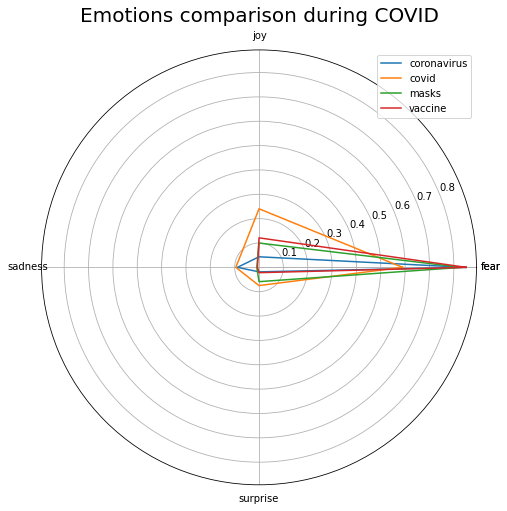

<Figure size 432x288 with 0 Axes>

In [36]:
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(coronavirus))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, coronavirus, label='coronavirus')
plt.plot(label_loc, covid, label='covid')
plt.plot(label_loc, masks, label='masks')
plt.plot(label_loc, vaccine, label='vaccine')
plt.title('Emotions comparison during COVID', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()
plt.savefig('plots/nlp/emotions_radar.png')

Looking at the graph it can be very easily inferred that the general emotion while talking about COVID is fear, which makes sense. However, tthe second highest used emotion is joy. This makes us wonder about the context of such comments. One context could be that people are talking about it in a sarcastic way. So we deep dive into this context further in our next plot.

In [37]:
covid_summary_sentiment_df

,Covid,emotion_class,Activity_x,avg_score,sum_contro,avg_sarcasm,avg_sentiment,total_awards,Activity_y,activity_percent
0,corona,fear,2100,2.400000,16,0.080818,0.525513,6,3441,0.610288
1,corona,surprise,448,3.607143,4,0.028803,0.650926,0,3441,0.130195
2,corona,sadness,345,2.637681,3,0.062001,0.359505,1,3441,0.100262
3,corona,joy,548,2.598540,1,0.158741,0.499180,0,3441,0.159256
4,coronavirus,fear,19921,1.769590,41,0.033086,0.155295,10,23452,0.849437
5,coronavirus,surprise,433,2.572748,4,0.052551,0.637931,0,23452,0.018463
6,coronavirus,joy,1019,2.838077,5,0.206271,0.502881,2,23452,0.043450
7,coronavirus,sadness,2079,1.265512,1,0.015898,0.092720,1,23452,0.088649
8,covid,joy,4885,8.207779,16,0.259009,0.503244,19,20305,0.240581
9,covid,fear,11967,5.484499,121,0.165166,0.497505,33,20305,0.589362


In [38]:
covid_summary_sentiment_df['sarcasm_label'] = round(covid_summary_sentiment_df['avg_sarcasm'], 2)

In [39]:
base = alt.Chart(covid_summary_sentiment_df).encode(
    x = alt.X("Covid", title="COVID Tag"),
    y=alt.Y("emotion_class", title="Emotion"),
    color='sarcasm_label',
    tooltip=[alt.Tooltip('sarcasm_label')]
).properties(
    width=600,
    height=300
)

# Text layer with correlation labels
# Colors are for easier readability
text = base.mark_text().encode(
    text='sarcasm_label',
    color=alt.condition(
        alt.datum.avg_sarcasm > 0.2, 
        alt.value('white'),
        alt.value('black')
    )
)


# The correlation heatmap itself
cor_plot = base.mark_rect().encode(
    color='sarcasm_label'
)

cor_plot = cor_plot + text # The '+' means overlaying the text and rect layer
cor_plot.save("plots/nlp/sarcasm_emotions_heatmap.html")
cor_plot

alt.LayerChart(...)

In [40]:
covid_summary_sentiment_df['text'] = 1
covid_summary_sentiment_df['text_y'] = "sadness"
sarcasm_emotions = (
        alt.Chart(covid_summary_sentiment_df)
        .mark_bar(height = 50)
        .encode(
            x = alt.X("sum(avg_sarcasm)", title="Sarcasm Level"),
            y=alt.Y("emotion_class", title="Emotion"),
            color='Covid',
            tooltip=[alt.Tooltip('avg_sarcasm')]
        )
    ).properties(height=alt.Step(80),title={
      "text": ["Do people make sarcastic remarks for COVID"], 
      "subtitle": ["Plot of emotions and their sarcasm level in COVID"]
    },).interactive()

text = alt.Chart(covid_summary_sentiment_df).mark_text(opacity = 0.1,
    text='Sarcasm Level of Joy is high', angle=0
).encode(
    x='text', y="text_y"
)


sarcasm_emotions = alt.layer(
    sarcasm_emotions,text
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
)
sarcasm_emotions.save("plots/nlp/sarcasm_emotions.html")
sarcasm_emotions

alt.LayerChart(...)

Looking at the plot, we can see that Sarcasm level is the highest in the emotion "joy" which is in accrdance to out hypothesis.

#### Sarcasm vs Controversiality

In [59]:
reddit_sentiment_rounded = reddit_sentiment.withColumn("sarcasm_value",F.round(reddit_sentiment["sarcasm_value"],1))
reddit_sentiment_rounded = reddit_sentiment_rounded.withColumn("sentiment_value",F.round(reddit_sentiment["sentiment_value"],1))

In [61]:
sarcasm_summary = reddit_sentiment_rounded.groupBy("sarcasm_value").agg(F.count("sarcasm_value").alias('Activity'),\
                                                              F.avg("score").alias('avg_score'),\
                                                              F.sum("gilded").alias('avg_gild'),\
                                                              F.sum("controversiality").alias('avg_contro'))

In [62]:
sarcasm_summary_df = sarcasm_summary.toPandas()

In [63]:
sarcasm_summary_df

,sarcasm_value,Activity,avg_score,avg_gild,avg_contro
0,NaN,0,3.215110,9,649
1,1.0,394823,8.067767,81,3521
2,0.3,69422,7.760076,35,768
3,0.4,57327,5.707729,9,654
4,0.8,68537,8.487182,29,765
5,0.2,99797,6.853523,33,1153
6,0.7,56106,7.491766,16,620
7,0.1,215704,7.004497,61,2486
8,0.6,51268,7.231782,12,557
9,0.5,52183,7.084702,25,612


In [69]:
sarcasm_summary_df = sarcasm_summary_df[sarcasm_summary_df["sarcasm_value"]>0]

In [79]:
alt.data_transformers.disable_max_rows()
click = alt.selection_multi(encodings=['color'])
timeunit='date'
# EXAMPLE

sarcasm_summary_df['text'] = 0.8
sarcasm_summary_df['text_y'] = 3500
sarcasm_summary_df['text1'] = 0.2
sarcasm_summary_df['text_y1'] = 3500
sarcasm_summary_df['a'] = 3650
sarcasm_summary_df['Start'] = 0.5
sarcasm_summary_df['Middle'] = 1.1
sarcasm_summary_df['Start2'] = 0
sarcasm_summary_df['Middle2'] = 0.5

sarcasm_plot = (
        alt.Chart(sarcasm_summary_df)
        .mark_bar(width = 30)
        .encode(
            x = alt.X("sarcasm_value", title="Average Sarcasm Value",scale=alt.Scale(domain=[0.1, 1])),
            y=alt.Y("avg_contro", title="Total Controversial Comments",scale=alt.Scale(domain=[0, 4500])),
            color=alt.value('#fc9272'),
            tooltip=[alt.Tooltip('avg_score')]
        )
    ).properties(width=600,title={
      "text": ["Is controversiality dependent on a sarcastic remark?"], 
      "subtitle": ["Plot of avg sarcasm value against total controversial comments"]
    },).interactive()



rect = alt.Chart(sarcasm_summary_df).mark_rect(color='#a6bddb',opacity=0.01).encode(
    x='Start',
    y=alt.value(300),
    x2='Middle',
    y2=alt.value(0))

rect2 = alt.Chart(sarcasm_summary_df).mark_rect(color='#edf8b1',opacity=0.01).encode(
    x='Start2',
    y=alt.value(300),
    x2='Middle2',
    y2=alt.value(0))

text2 = alt.Chart(sarcasm_summary_df).mark_text(opacity = 0.1,size =14,
    text='Sarcastic Comment', angle=0
).encode(
    x='text', y="text_y"
)

text = alt.Chart(sarcasm_summary_df).mark_text(opacity = 0.1,size =14,
    text='Normal Comment', angle=0
).encode(
    x='text1', y="text_y1"
)


threshold =(
    alt.Chart(sarcasm_summary_df)
    .mark_rule()
    .encode(
        x = 'a'
    )
)
sarcasm_plot = alt.layer(
    sarcasm_plot,rect,rect2,text2,text
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
)

sarcasm_plot.save("plots/nlp/sarcasm_contro.html")
sarcasm_plot

/mnt/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/mnt/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

alt.LayerChart(...)

We can see that the with a very low and very high sarcasm level, the number of controversial comments seem to be high. 

#### Sentiment in Awards

In [78]:
awards_summary_sentiment = reddit_sentiment_rounded.groupBy("Awards").agg(\
                                                              F.count("Awards").alias('Activity'),\
                                                              F.avg("score").alias('avg_score'),\
                                                              F.sum("controversiality").alias('sum_contro'),\
                                                              F.avg("sarcasm_value").alias('avg_sarcasm'),\
                                                              F.avg("sentiment_value").alias('avg_sentiment'))

In [79]:
awards_summary_sentiment = awards_summary_sentiment.orderBy(awards_summary_sentiment.Activity.desc()).limit(20)

In [80]:
awards_summary_sentiment_df = awards_summary_sentiment.toPandas()

In [81]:
awards_summary_sentiment_df

,Awards,Activity,avg_score,sum_contro,avg_sarcasm,avg_sentiment
0,,7359611,5.159536,67308,0.102143,0.664832
1,Silver,3499,767.906545,71,0.095986,0.697251
2,Helpful,1947,430.834104,28,0.095133,0.699685
3,Hugz,1815,1085.240771,27,0.110911,0.679009
4,Wholesome,1254,422.718501,29,0.088475,0.719389
5,Gold,1144,357.777098,56,0.075893,0.702649
6,Take My Energy,693,1259.603175,28,0.119762,0.665406
7,All-Seeing Upvote,425,170.451765,17,0.194962,0.618561
8,This,300,489.243333,13,0.122910,0.618322
9,Rocket Like,292,539.342466,4,0.059502,0.701856


#### Different Approach

In [86]:
reddit_sentiment_rounded.printSchema()

root
 |-- document: string (nullable = true)
 |-- sarcasm_class: string (nullable = true)
 |-- sarcasm_value: double (nullable = true)
 |-- sentiment_class: string (nullable = true)
 |-- sentiment_value: double (nullable = true)
 |-- emotion_class: string (nullable = true)
 |-- score: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- Awards: string (nullable = true)
 |-- Jokes: string (nullable = true)
 |-- Covid: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- reddit_age_post: integer (nullable = true)
 |-- is_award: integer (nullable = true)



In [91]:
awards_summary_sentiment2 = reddit_sentiment_rounded.groupBy("Awards","sentiment_class","sarcasm_class").agg(\
                                                              F.count("Awards").alias('Activity'),\
                                                              F.avg("score").alias('avg_score'),\
                                                              F.sum("controversiality").alias('sum_contro'),\
                                                              F.avg("sarcasm_value").alias('avg_sarcasm'),\
                                                              F.avg("sentiment_value").alias('avg_sentiment'))

In [92]:
awards_summary_sentiment_df2 = awards_summary_sentiment2.toPandas()

In [93]:
awards_summary_sentiment_df2

,Awards,sentiment_class,sarcasm_class,Activity,avg_score,sum_contro,avg_sarcasm,avg_sentiment
0,Candy Cane,positive,normal,1,11.000000,0,0.490464,1.000000
1,All-Seeing Upvote,negative,normal,104,109.798077,4,0.040419,0.054038
2,Looking Busy,neutral,normal,1,5.000000,0,0.000649,0.500000
3,Excited,positive,normal,80,1250.250000,0,0.008833,0.965250
4,Candy Corn Upvote,negative,normal,12,1663.333333,0,0.005044,0.065000
...,...,...,...,...,...,...,...,...
491,Rocket Like,positive,normal,187,547.967914,3,0.009345,0.973583
492,Healthcare Hero,neutral,normal,1,5.000000,0,0.000071,0.570000
493,Bless Up,positive,normal,46,1029.978261,0,0.002014,0.951304
494,Aww-some,negative,sarcasm,1,41.000000,0,0.557206,0.000000


In [96]:
reqd_awards = ['Hugz','Wholesome','Helpful','Take My Energy','Facepalm']
awards_summary_sentiment_df_filter = awards_summary_sentiment_df2[awards_summary_sentiment_df2['Awards'].isin(reqd_awards)].sort_values(by = ["Awards"])

In [102]:
awards_summary_sentiment_df_filter = awards_summary_sentiment_df_filter[awards_summary_sentiment_df_filter['sentiment_class']!='neutral']
awards_summary_sentiment_df_filter = awards_summary_sentiment_df_filter[awards_summary_sentiment_df_filter['sentiment_class']!='None']



In [103]:
awards_summary_sentiment_df_filter

,Awards,sentiment_class,sarcasm_class,Activity,avg_score,sum_contro,avg_sarcasm,avg_sentiment
419,Facepalm,positive,normal,53,475.132075,0,0.013058,0.949811
39,Facepalm,positive,sarcasm,2,2122.000000,0,0.928370,1.000000
452,Facepalm,negative,normal,19,733.578947,1,0.041005,0.072632
200,Facepalm,negative,sarcasm,6,1425.666667,0,0.825066,0.060000
312,Helpful,negative,sarcasm,78,655.179487,1,0.906783,0.064872
261,Helpful,positive,sarcasm,89,341.426966,1,0.870727,0.959663
216,Helpful,positive,normal,1227,415.375713,17,0.014231,0.969943
196,Helpful,negative,normal,461,460.941432,8,0.021798,0.070217
237,Helpful,None,None,11,4.454545,0,NaN,NaN
195,Hugz,None,None,18,313.666667,2,NaN,NaN
